## 多分类问题简单回顾

在二分类问题中，我们可以使用sigmoid函数。而在多分类问题中，我们希望将输入数据划分到超过两个类别中的一个。这种情况下，我们通常使用一种叫做 "softmax" 的函数。

我们将神经网络的最后一层称为 "softmax层"。这一层的输出是一个概率分布，表示输入数据属于每个类别的概率。为了计算这些概率，我们使用 softmax 函数。

让我们假设有 K 个类别，其中第 k 个类别的概率为 $p_k$。我们将最后一层的输出（即 logits）记为 $z_1，z_2，…，z_k$。那么根据 softmax 函数的定义，每个类别的概率可以计算为：

$$ p_k = \frac{exp(z_k)}{\sum_{i=1}^{k} exp(z_i)} $$

这个过程是对所有 K 个 logits 应用指数函数，然后将它们归一化为概率分布。

在训练神经网络时，我们通常使用交叉熵损失函数来度量预测值与真实值之间的差距。对于多分类问题，交叉熵损失函数可以计算为：

$$ L = - \sum_{i=1}^{k} y_i \times log(p_i) $$

其中 $y_i$ 是真实值，$p_i$ 是预测值。

通过最小化交叉熵损失函数，我们可以训练出模型的参数。当我们训练完神经网络后，我们就可以使用它来进行多分类。为了做出预测，我们需要将输入数据输入到神经网络中，并根据输出的概率分布来决定它属于哪个类别。

使用 softmax 函数和交叉熵损失函数是一种多分类的常见的方法。

## 代码实现

### 加载MNIST数据集

In [14]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [15]:
# 定义数据转换方式：将图像数据转换为PyTorch张量格式
transformation = torchvision.transforms.ToTensor()
# 加载MNIST训练数据集
train_dataset = torchvision.datasets.MNIST(root='../data/mnist', train=True, download=True, transform=transformation)
# 加载MNIST测试数据集
test_dataset = torchvision.datasets.MNIST(root='../data/mnist', train=False, download=True, transform=transformation)

### 数据加载器

In [16]:
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

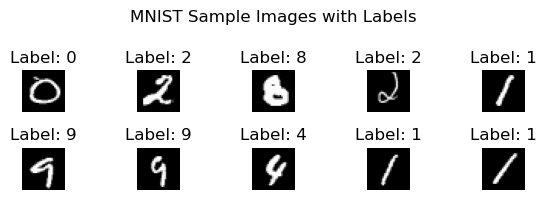

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(6, 2))
fig.suptitle('MNIST Sample Images with Labels')

for i, (images, labels) in enumerate(train_dataloader):
    if i == 0:  # Only use the first batch
        for idx in range(10):
            row = idx // 5
            col = idx % 5
            axes[row, col].imshow(images[idx][0], cmap='gray')
            axes[row, col].axis('off')
            axes[row, col].set_title(f'Label: {labels[idx].item()}')
        break

plt.tight_layout()
plt.show()

### 构建网络

In [18]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        logits = self.linear(x)
        return logits


In [19]:
# 因为MNIST图像是28x28的灰度图，所以输入大小为28*28=784
# 因为有10个数字类别，所以输出大小为10
input_size = 28 * 28
output_size = 10
model = Model(input_size, output_size)

### 损失函数和优化器

In [20]:
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # 使用随机梯度下降优化器

### 模型评估

In [ ]:
def evaluate(model, data_loader):
    # 将模型设置为评估模式（关闭dropout等训练特性）
    model.eval()
    # 初始化计数器
    correct = 0  # 正确预测的样本数
    total = 0    # 总样本数
    
    # 使用torch.no_grad()来停止梯度计算，节省内存并加快推理速度
    with torch.no_grad():
        # 遍历数据加载器中的每个批次
        for x, y in data_loader:
            # 将输入图像展平为一维向量 (batch_size, 784)
            x = x.view(-1, input_size)
            
            # 通过模型获取预测结果（logits）
            # 当调用model(x)时，Python会自动调用model对象的__call__方法
            # __call__方法在内部会调用forward方法
            # 这是Python的一种语法糖，让对象可以像函数一样被调用
            # 在PyTorch中，所有nn.Module的子类都继承了这个特性
            # 直接调用forward方法也可以，但不推荐，因为这样会跳过__call__中的一些预处理步骤
            # logits = model.forward(x)
            logits = model(x)
            
            
            # torch.max返回两个值：最大值和对应的索引
            # [1]表示在维度1上取最大值（即在每行中找最大值）
            # predicted中存储的是每个样本预测的类别
            _, predicted = torch.max(logits.data, 1)
            
            # 累加当前批次的样本总数
            total += y.size(0)
            
            # 计算并累加当前批次中预测正确的样本数
            correct += (predicted == y).sum().item()
    
    # 返回准确率（正确预测的样本数 / 总样本数）
    return correct / total

### 模型训练

In [23]:
for epoch in range(10):
    model.train()
    for images, labels in train_dataloader:
        # 将图像和标签转换成张量
        images = images.view(-1, 28*28)
        # 将标签转换为长整型，因为CrossEntropyLoss要求标签必须是长整型（torch.long）类型
        labels = labels.long()

        outputs = model(images)  # 前向传播
        loss = criterion(outputs, labels) # 计算损失
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    accuracy = evaluate(model, test_dataloader)
    print(f'Epoch {epoch}: test accuracy = {accuracy:.2f}')

Epoch 0: test accuracy = 0.91
Epoch 1: test accuracy = 0.91
Epoch 2: test accuracy = 0.91
Epoch 3: test accuracy = 0.91
Epoch 4: test accuracy = 0.91
Epoch 5: test accuracy = 0.91
Epoch 6: test accuracy = 0.92
Epoch 7: test accuracy = 0.92
Epoch 8: test accuracy = 0.92
Epoch 9: test accuracy = 0.92
